# Equivalent Circuit Parameter Identification

This notebook provides example usage for identifying stationary parameters for a two RC branch Thevenin model. The Thevenin model represents an electrochemical battery through an empirical circuit model capable of capturing the electrical response of the battery. This model can be extended with a thermal submodel, as well as additional parallel resistor-capacitor branches.

### Setting up the Environment

Before we begin, we need to ensure that we have all the necessary tools. We will install PyBOP from its development branch and upgrade some dependencies:

In [ ]:
%pip install --upgrade pip ipywidgets -q
%pip install pybop -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Importing Libraries

With the environment set up, we can now import PyBOP alongside other libraries we will need:

In [ ]:
import numpy as np
import pybamm

import pybop

Let's fix the random seed in order to generate consistent output during development, although this does not need to be done in practice.

In [ ]:
np.random.seed(8)

## Importing Parameters

This can be completed by importing a JSON representation, such as the one in the PyBOP [examples](https://github.com/pybop-team/PyBOP/blob/develop/examples/scripts/parameters/initial_ecm_parameters.json). To import via JSON, either download the example file, or create your own and update the path below to reference the corresponding file.

In [ ]:
# parameter_set = pybop.ParameterSet(
# json_path="examples/scripts/parameters/initial_ecm_parameters.json"
# )
# parameter_set.import_parameters()

Alternatively, define the initial parameter set by updating the default ECM parameters used in PyBaMM. Ensure you have definitions for all R's, C's, and initial overpotentials for any additional RC elements.

In this example, we use the default parameter value for the "Open-circuit voltage [V] as provided by the original PyBaMM class. To update this, provide a function definition that matches this [function](https://github.com/pybamm-team/PyBaMM/blob/1943aa5ab2895b5378220595923dbae3d66b13c9/pybamm/input/parameters/ecm/example_set.py#L17).

In [ ]:
parameter_set = pybamm.ParameterValues("ECM_Example")
parameter_set.update(
    {
        "Cell capacity [A.h]": 5,
        "Nominal cell capacity [A.h]": 5,
        "Current function [A]": 5,
        "Initial SoC": 0.5,
        "Element-1 initial overpotential [V]": 0,
        "Upper voltage cut-off [V]": 4.2,
        "Lower voltage cut-off [V]": 3.0,
        "R0 [Ohm]": 1e-3,
        "R1 [Ohm]": 2e-4,
        "C1 [F]": 1e4,
        "Open-circuit voltage [V]": pybop.empirical.Thevenin().default_parameter_values[
            "Open-circuit voltage [V]"
        ],
    }
)
# Optional arguments - only needed for two RC pairs
parameter_set.update(
    {
        "R2 [Ohm]": 0.0003,
        "C2 [F]": 40000,
        "Element-2 initial overpotential [V]": 0,
    },
    check_already_exists=False,
)

## Identifying the Parameters

Now that the initial parameter set is constructed, we can start the PyBOP fitting process. First, we define the model class with two RC elements.

In [ ]:
model = pybop.empirical.Thevenin(
    parameter_set=parameter_set, options={"number of rc elements": 2}
)

In this example, we are going to try to fit all five parameters at once. This isn't recommend for real-life application as identifiablity is challenging to guarantee with this large a parameter space. To do this, we define the `pybop.Parameters` as,

In [ ]:
parameters = pybop.Parameters(
    pybop.Parameter(
        "R0 [Ohm]",
        prior=pybop.Gaussian(2 - 4, 1e-4),
        bounds=[1e-4, 1e-2],
    ),
    pybop.Parameter(
        "R1 [Ohm]",
        prior=pybop.Gaussian(1e-4, 1e-4),
        bounds=[1e-5, 1e-2],
    ),
    pybop.Parameter(
        "R2 [Ohm]",
        prior=pybop.Gaussian(1e-4, 1e-4),
        bounds=[1e-5, 1e-2],
    ),
    pybop.Parameter(
        "C1 [F]",
        prior=pybop.Gaussian(1e4, 5e2),
        bounds=[2.5e3, 5e4],
    ),
    pybop.Parameter(
        "C2 [F]",
        prior=pybop.Gaussian(1e4, 5e2),
        bounds=[2.5e3, 5e4],
    ),
)

Let's create some synthetic data to identify the parameters. This data is then corrupted with a small amount of Gaussian noise to represent some additional uncertainty in the measured values. We can then form the `pybop.Dataset` from this data.

In [ ]:
sigma = 0.001
t_eval = np.arange(0, 900, 3)
values = model.predict(t_eval=t_eval)
corrupt_values = values["Voltage [V]"].data + np.random.normal(0, sigma, len(t_eval))

# Form dataset
dataset = pybop.Dataset(
    {
        "Time [s]": t_eval,
        "Current function [A]": values["Current [A]"].data,
        "Voltage [V]": corrupt_values,
    }
)

The `FittingProblem` class provides us with a single class that holds all of the objects we need to evaluate our selected `SumSquaredError` cost function. 

In [ ]:
problem = pybop.FittingProblem(model, parameters, dataset)
cost = pybop.SumSquaredError(problem)

The cost function can be interrogated manually via the `cost([params])` API. In this example, that would look like the following,

In [ ]:
cost([0.001, 0.001, 0.001, 5000, 5000])

0.017324210933474568

Next, we construct the optimisation class with our algorithm of choice and run it. In this case, we select the CMA-ES method as it provides global optimisation capability. For the sake of reducing the runtime of this example, we limit the maximum iterations to 100; however, feel free to update this value.

In [ ]:
optim = pybop.XNES(
    cost,
    sigma0=[1e-4, 1e-4, 1e-4, 10, 10],
    max_unchanged_iterations=50,
    max_iterations=250,
)
x, final_cost = optim.run()
print("Initial parameters:", optim.x0)
print("Estimated parameters:", x)

Initial parameters: [1.00990000e-04 2.09128273e-04 1.09990000e-05 9.30682523e+03
 8.85175421e+03]
Estimated parameters: [5.99820152e-04 3.03981697e-04 5.82189226e-04 9.30176524e+03
 8.85501768e+03]


## Plotting and Visualisation

PyBOP provides various plotting utilities to visualize the results of the optimisation.

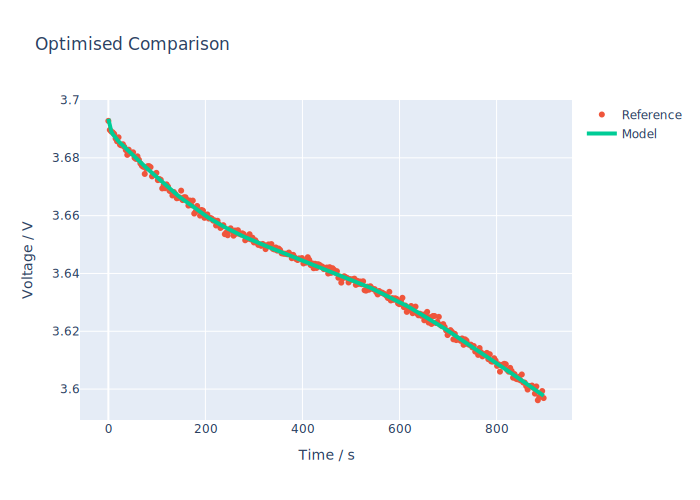

In [ ]:
pybop.quick_plot(problem, problem_inputs=x, title="Optimised Comparison");

### Convergence and Parameter Trajectories

To assess the optimisation process, we can plot the convergence of the cost function and the trajectories of the parameters:

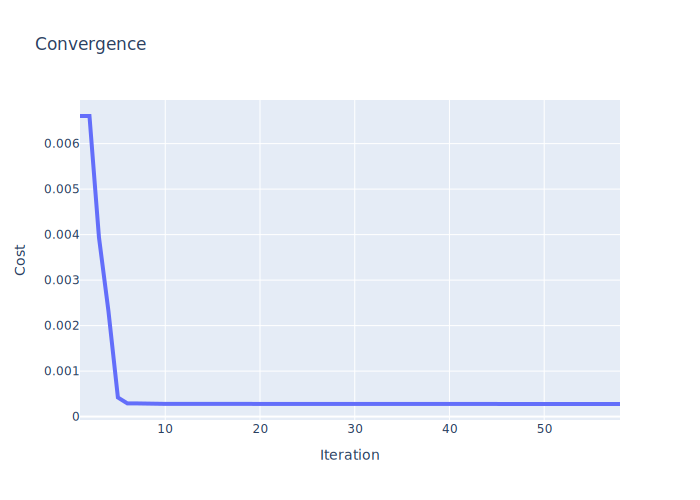

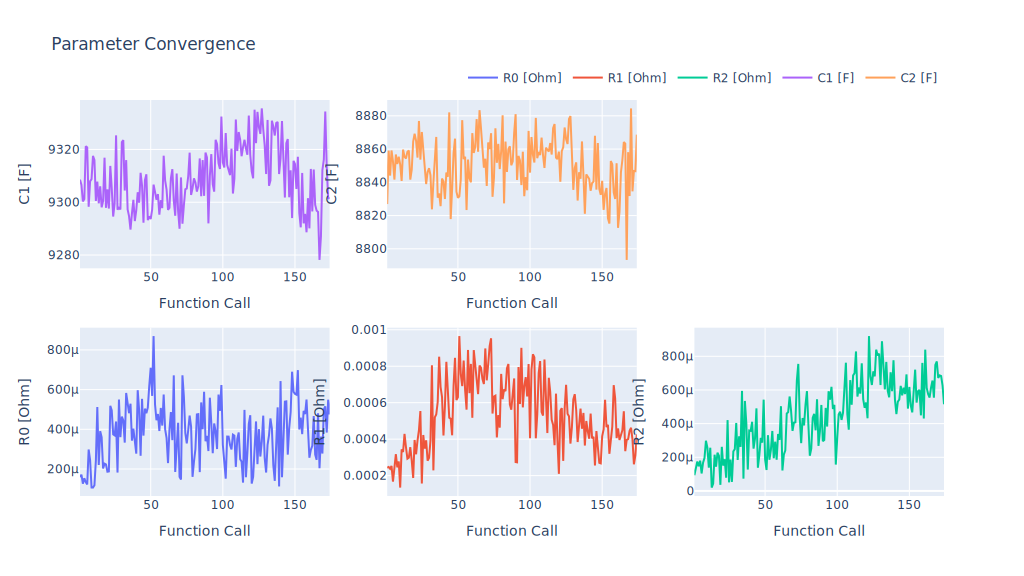

In [ ]:
pybop.plot_convergence(optim)
pybop.plot_parameters(optim);

### Conclusion

This notebook illustrates how to perform parameter estimation using CMA-ES in PyBOP, providing insights into the optimisation process through various visualisations.